In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn import set_config
set_config(display='diagram')
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
filename = "C:/Users/rodlu/OneDrive/Escritorio/Coding_Dojo/Data_Science/Data sets/credit_customers.csv"
df = pd.read_csv(filename)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [3]:
# Crear una copia del dataframe original
df_1 = df.copy()

In [4]:
# Inspeccionar el dataframe
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [5]:
# Reemplazar valores inconsistentes en la columna 'credit_history': 'no credits/all paid' por 'no credits'
df_1['credit_history'] = df_1['credit_history'].replace('no credits/all paid', 'no credits')
df_1['credit_history'] = df_1['credit_history'].replace('all paid', 'no credits')
# Reemplazar valores con mwnos de 90 en la columna 'purpose' por 'other'
df_1['purpose'] = df_1['purpose'].replace('education', 'other')
df_1['purpose'] = df_1['purpose'].replace('repairs', 'other')
df_1['purpose'] = df_1['purpose'].replace('domestic appliance', 'other')
df_1['purpose'] = df_1['purpose'].replace('retraining', 'other')
# Reemplazar valores por > 100 y mantener < 100 y 'no known savings'
df_1['savings_status'] = df_1['savings_status'].replace('100<=X<500', '>100')
df_1['savings_status'] = df_1['savings_status'].replace('500<=X<1000', '>100')
df_1['savings_status'] = df_1['savings_status'].replace('>=1000', '>100')
# Dividir la columna personal_status en dos clumnas: gender y marital_status
df_1[['gender', 'marital_status']] = df_1['personal_status'].str.split(' ', n=1, expand=True)
# Eliminar la columna 'personal_status'
df_1.drop('personal_status', axis=1, inplace=True)
# Reemplazar valores en la columna 'marital_status'
df_1['marital_status'] = df_1['marital_status'].replace('mar/wid', 'not single')
df_1['marital_status'] = df_1['marital_status'].replace('div/sep', 'not single')
df_1['marital_status'] = df_1['marital_status'].replace('div/dep/mar', 'not single')
# convertir la columna 'job' en una columna binaria skilled y unskilled
df_1['job']=df_1['job'].replace('unemp/unskilled non res', 'unskilled')
df_1['job']=df_1['job'].replace('unskilled resident', 'unskilled')
df_1['job']=df_1['job'].replace('high qualif/self emp/mgmt', 'skilled')
# convertir la columna objetivo en numerica
df_1['class']=df_1['class'].replace('good', 1)
df_1['class']=df_1['class'].replace('bad', 0)

In [6]:
# mostrar los valores unicos y el type de la columna por columna en orden ascendente
for col in df_1.columns:
    print(col, ':', len(df_1[col].unique()),'valores unicos /', df_1[col].dtype, 'type')


checking_status : 4 valores unicos / object type
duration : 33 valores unicos / float64 type
credit_history : 4 valores unicos / object type
purpose : 6 valores unicos / object type
credit_amount : 921 valores unicos / float64 type
savings_status : 3 valores unicos / object type
employment : 5 valores unicos / object type
installment_commitment : 4 valores unicos / float64 type
other_parties : 3 valores unicos / object type
residence_since : 4 valores unicos / float64 type
property_magnitude : 4 valores unicos / object type
age : 53 valores unicos / float64 type
other_payment_plans : 3 valores unicos / object type
housing : 3 valores unicos / object type
existing_credits : 4 valores unicos / float64 type
job : 2 valores unicos / object type
num_dependents : 2 valores unicos / float64 type
own_telephone : 2 valores unicos / object type
foreign_worker : 2 valores unicos / object type
class : 2 valores unicos / int64 type
gender : 2 valores unicos / object type
marital_status : 2 valores 

In [7]:
df_1['class'].value_counts(normalize=True)

1    0.7
0    0.3
Name: class, dtype: float64

In [8]:
#Formato para ML y train test split
X = df_1.drop(columns = 'class')
y = df_1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)
# Instanciar los selectores de columnas categóricas y numéricas para seleccionar las columnas adecuadas
num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_include=object)
# Instanciar el escalador estándar y el codificador one hot
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
# Make tuples for preprocessing the categorical and numeric columns
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)
#Instanciación de ColumnTransformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
#Observen que SOLO ENCAJAREMOS LOS DATOS DE ENTRENAMIENTO
col_transformer.fit(X_train)
#Ahora podemos transformar los conjuntos de entrenamiento y de prueba.
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)
#Ver las transformaciones en dataframe
X_train_df = pd.DataFrame(X_train_processed)
X_test_df = pd.DataFrame(X_test_processed)
print(np.isnan(X_train_df).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_df).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_df.shape)
print('\n')
X_train_df.head()

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (750, 52)




,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.244061,2.684089,-0.845753,-0.765547,0.853000,0.986324,2.291288,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.255316,-0.680787,0.931039,-1.669735,-0.838754,0.986324,-0.436436,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.733429,-0.745299,0.931039,1.042831,-1.105872,-0.710335,-0.436436,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.255316,-0.916502,0.931039,1.042831,1.654357,0.986324,-0.436436,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.486243,-0.833913,0.931039,0.138642,-0.215476,0.986324,2.291288,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


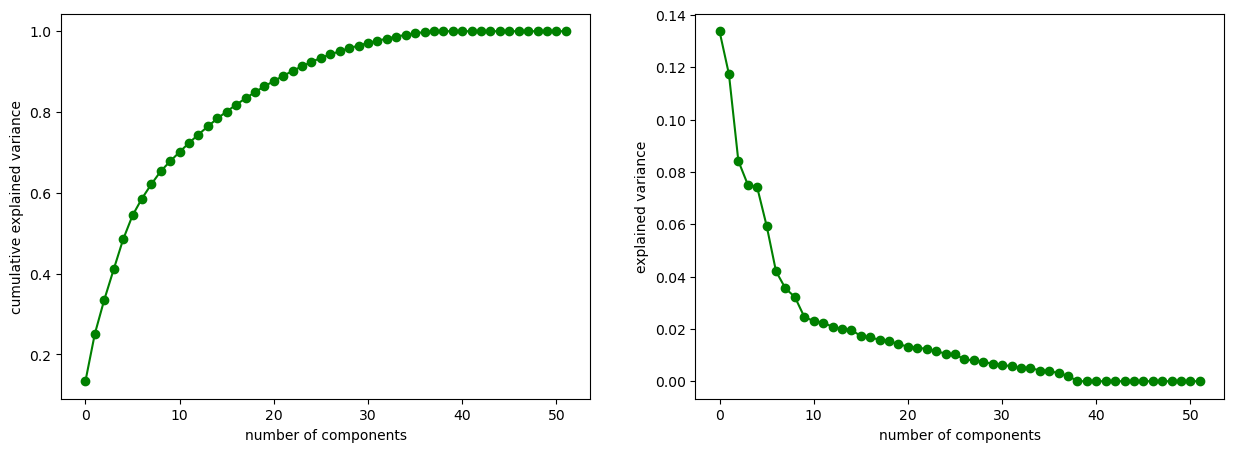

In [9]:
# Instantiate & fit data using PCA default settings
pca = PCA()
pca.fit(X_train_df)
# Plot the cumulative sum of the explained variance ratio and Plot the explained variance ratio uno al lado del otro
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'go-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_, 'go-')
plt.xlabel('number of components')
plt.ylabel('explained variance');
plt.show()

In [10]:
# PCA with 85% explained variance
pca = PCA(n_components=0.85)
pca.fit(X_train_df)
X_train_pca = pca.transform(X_train_df)
X_test_pca = pca.transform(X_test_df)
print('shape of data is', X_train_pca.shape)
print('\n')
print('shape of data is', X_test_pca.shape)
print('\n')
print('All data in X_train_pca are', X_train_pca.dtype)
print('All data in X_test_pca are', X_test_pca.dtype)
print('\n')
print(np.isnan(X_train_pca).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_pca).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_pca are', X_train_pca.dtype)
print('All data in X_test_pca are', X_test_pca.dtype)
print('\n')
print('shape of data is', X_train_pca.shape)
print('\n')
X_train_pca_df = pd.DataFrame(X_train_pca)
X_test_pca_df = pd.DataFrame(X_test_pca)
X_train_pca_df.head()

shape of data is (750, 20)


shape of data is (250, 20)


All data in X_train_pca are float64
All data in X_test_pca are float64


0 missing values in training data
0 missing values in testing data


All data in X_train_pca are float64
All data in X_test_pca are float64


shape of data is (750, 20)




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.496965,0.424254,1.954184,-0.847357,0.102756,0.185018,0.525364,0.972926,-0.342035,-0.352714,-0.478723,-0.122240,0.010618,1.006673,0.371130,-0.213070,0.224866,-0.196820,0.174297,-0.420335
1,-0.297974,0.023820,-0.310452,-2.459037,0.515840,0.153916,-0.584136,0.167988,-0.476894,0.305572,0.614617,0.093269,-0.180764,-0.951013,-0.371915,-0.091088,1.018021,-0.164942,0.144058,0.075663
2,-1.262315,-0.504697,-1.340324,1.013967,-0.238901,-1.524456,-0.296441,0.765855,-0.929960,0.781758,0.532886,0.169729,-0.459586,-0.896012,0.431134,0.288077,-0.656563,0.883862,0.421599,0.546264
3,0.287597,2.035339,-1.560286,0.167640,0.451849,0.557205,0.130082,1.215025,0.328514,-0.422126,-0.174890,0.293950,-0.059984,-0.293218,0.263967,0.014695,0.742795,-0.162112,0.109920,0.082568
4,-0.221700,1.839579,0.922475,-0.922480,-0.641664,-1.866211,0.397475,-0.349982,-0.790015,-0.052072,-0.743049,0.413675,0.563297,-0.008549,0.905418,-0.108036,0.323623,-0.545231,-0.186510,0.052375


In [11]:
# Step 1: Define our network structure
# Save the number of features we have as our input shape
input_shape = X_train_pca_df.shape[1]
input_shape

20

In [12]:
# Luego podemos definir nuestro tipo de modelo.
# Sequential model
model = Sequential()
model.add(Dense(20, input_shape=(input_shape,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model
history = model.fit(X_train_pca_df, y_train, validation_data=(X_test_pca_df, y_test), epochs=30, verbose=2)

Epoch 1/30
24/24 - 3s - loss: 0.6252 - accuracy: 0.7000 - val_loss: 0.6078 - val_accuracy: 0.7000 - 3s/epoch - 138ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6083 - accuracy: 0.7000 - val_loss: 0.5970 - val_accuracy: 0.7000 - 175ms/epoch - 7ms/step
Epoch 3/30
24/24 - 0s - loss: 0.5936 - accuracy: 0.7000 - val_loss: 0.5883 - val_accuracy: 0.7000 - 133ms/epoch - 6ms/step
Epoch 4/30
24/24 - 0s - loss: 0.5804 - accuracy: 0.7000 - val_loss: 0.5812 - val_accuracy: 0.7000 - 143ms/epoch - 6ms/step
Epoch 5/30
24/24 - 0s - loss: 0.5680 - accuracy: 0.7000 - val_loss: 0.5750 - val_accuracy: 0.7000 - 119ms/epoch - 5ms/step
Epoch 6/30
24/24 - 0s - loss: 0.5565 - accuracy: 0.7000 - val_loss: 0.5700 - val_accuracy: 0.7000 - 125ms/epoch - 5ms/step
Epoch 7/30
24/24 - 0s - loss: 0.5445 - accuracy: 0.7000 - val_loss: 0.5656 - val_accuracy: 0.7000 - 123ms/epoch - 5ms/step
Epoch 8/30
24/24 - 0s - loss: 0.5338 - accuracy: 0.7000 - val_loss: 0.5632 - val_accuracy: 0.7000 - 126ms/epoch - 5ms/step
Epoch 9/30
24/24 

In [13]:
# Evaluate the model on the test set
model.evaluate(X_test_pca_df, y_test, verbose=2)

8/8 - 0s - loss: 0.5758 - accuracy: 0.6880 - 51ms/epoch - 6ms/step


[0.5757861137390137, 0.6880000233650208]

In [26]:
# calculate predictions and print metrics for the model
y_pred = model.predict(X_test_pca_df)
y_pred = np.round(y_pred)
# calcular la matriz de confusión
confusion_matrix(y_test, y_pred)
# calcular la precision
precision_score(y_test, y_pred)
# calcular el recall
recall_score(y_test, y_pred)
# calcular el f1
f1_score(y_test, y_pred)
# calcular el accuracy
accuracy_score(y_test, y_pred)
# calcular el roc_auc
roc_auc_score(y_test, y_pred)
# imprimir todos los resultados
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))
# imprimir la perdida
print('Loss: ', history.history['loss'][-1])

8/8 [==============================] - 0s 2ms/step
Confusion Matrix: 
 [[ 25  50]
 [ 28 147]]
Precision:  0.7461928934010152
Recall:  0.84
F1:  0.7903225806451613
Accuracy:  0.688
ROC_AUC:  0.5866666666666667
Loss:  0.41631102561950684


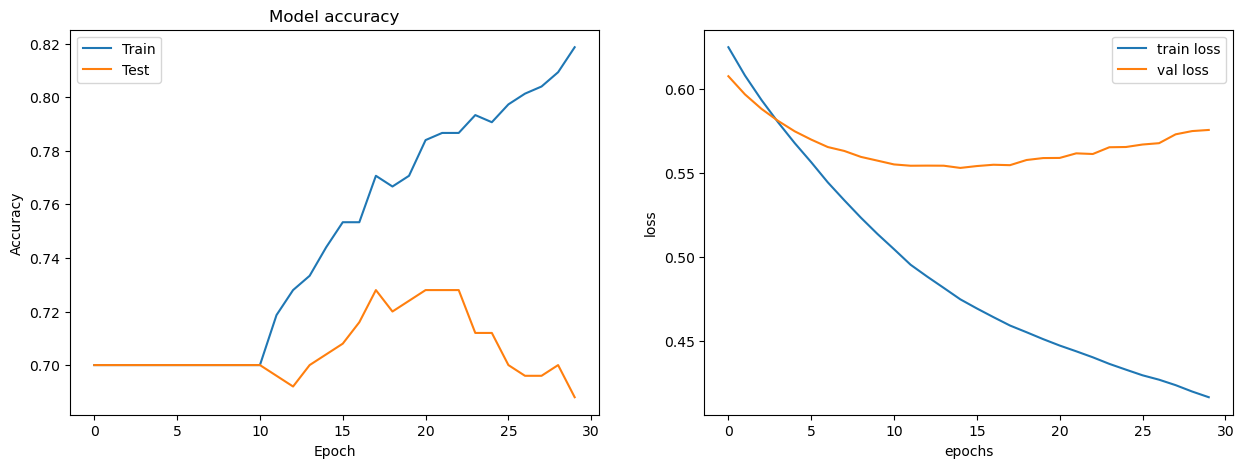

In [15]:
# Plot your model training history and plot loss uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot your model training history
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
# Visualize the loss
ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()
plt.show()

In [16]:
# Segundo modelo
# Sequential model
model2 = Sequential()
model2.add(Dense(20, input_shape=(input_shape,), activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# fit the model
history2=model2.fit(X_train_pca_df, y_train, validation_data=(X_test_pca_df, y_test), epochs=30, verbose=2, callbacks=[early_stopping])

Epoch 1/30
24/24 - 2s - loss: 0.7239 - accuracy: 0.4613 - val_loss: 0.6999 - val_accuracy: 0.5520 - 2s/epoch - 73ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6846 - accuracy: 0.6227 - val_loss: 0.6743 - val_accuracy: 0.6360 - 119ms/epoch - 5ms/step
Epoch 3/30
24/24 - 0s - loss: 0.6637 - accuracy: 0.6827 - val_loss: 0.6561 - val_accuracy: 0.6800 - 115ms/epoch - 5ms/step
Epoch 4/30
24/24 - 0s - loss: 0.6460 - accuracy: 0.6933 - val_loss: 0.6366 - val_accuracy: 0.6800 - 111ms/epoch - 5ms/step
Epoch 5/30
24/24 - 0s - loss: 0.6277 - accuracy: 0.7027 - val_loss: 0.6177 - val_accuracy: 0.7000 - 105ms/epoch - 4ms/step
Epoch 6/30
24/24 - 0s - loss: 0.6085 - accuracy: 0.7053 - val_loss: 0.6033 - val_accuracy: 0.6960 - 106ms/epoch - 4ms/step
Epoch 7/30
24/24 - 0s - loss: 0.5911 - accuracy: 0.7133 - val_loss: 0.5901 - val_accuracy: 0.6960 - 106ms/epoch - 4ms/step
Epoch 8/30
24/24 - 0s - loss: 0.5749 - accuracy: 0.7160 - val_loss: 0.5788 - val_accuracy: 0.6960 - 134ms/epoch - 6ms/step
Epoch 9/30
24/24 -

In [17]:
# evaluar el modelo
model2.evaluate(X_test_pca_df, y_test, verbose=2)

8/8 - 0s - loss: 0.5336 - accuracy: 0.7280 - 54ms/epoch - 7ms/step


[0.533589243888855, 0.7279999852180481]

In [27]:
# calculate predictions and print metrics for the model
y_pred2 = model2.predict(X_test_pca_df)
y_pred2 = np.round(y_pred2)
# calcular la matriz de confusión
confusion_matrix(y_test, y_pred2)
# calcular la precision
precision_score(y_test, y_pred2)
# calcular el recall
recall_score(y_test, y_pred2)
# calcular el f1
f1_score(y_test, y_pred2)
# calcular el accuracy
accuracy_score(y_test, y_pred2)
# calcular el roc_auc
roc_auc_score(y_test, y_pred2)
# imprimir todos los resultados
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred2))
print('Precision: ', precision_score(y_test, y_pred2))
print('Recall: ', recall_score(y_test, y_pred2))
print('F1: ', f1_score(y_test, y_pred2))
print('Accuracy: ', accuracy_score(y_test, y_pred2))
print('ROC_AUC: ', roc_auc_score(y_test, y_pred2))
# imprimir la perdida
print('Loss: ', history2.history['loss'][-1])

8/8 [==============================] - 0s 2ms/step
Confusion Matrix: 
 [[ 30  45]
 [ 23 152]]
Precision:  0.7715736040609137
Recall:  0.8685714285714285
F1:  0.8172043010752689
Accuracy:  0.728
ROC_AUC:  0.6342857142857143
Loss:  0.4037263095378876


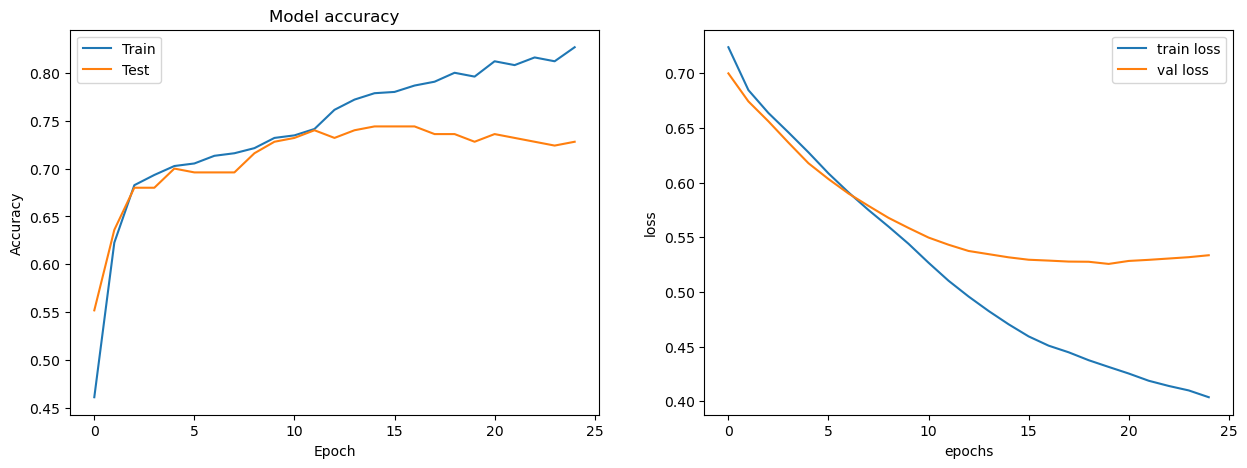

In [19]:
# Plot your model training history and plot loss uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot your model training history
ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
# Visualize the loss
ax2.plot(history2.history['loss'], label='train loss')
ax2.plot(history2.history['val_loss'], label='val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()
plt.show()

In [20]:
# Tercer modelo con regularización l2
# Sequential model
model3 = Sequential()
model3.add(Dense(20, input_shape=(input_shape,), activation='relu'))
model3.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dense(1, activation='sigmoid'))
# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model
history3=model3.fit(X_train_pca_df, y_train, validation_data=(X_test_pca_df, y_test), epochs=30, verbose=2)

Epoch 1/30
24/24 - 2s - loss: 0.8687 - accuracy: 0.5440 - val_loss: 0.8231 - val_accuracy: 0.6840 - 2s/epoch - 73ms/step
Epoch 2/30
24/24 - 0s - loss: 0.8124 - accuracy: 0.6960 - val_loss: 0.7816 - val_accuracy: 0.7000 - 127ms/epoch - 5ms/step
Epoch 3/30
24/24 - 0s - loss: 0.7756 - accuracy: 0.7067 - val_loss: 0.7494 - val_accuracy: 0.6920 - 119ms/epoch - 5ms/step
Epoch 4/30
24/24 - 0s - loss: 0.7437 - accuracy: 0.7067 - val_loss: 0.7241 - val_accuracy: 0.7000 - 161ms/epoch - 7ms/step
Epoch 5/30
24/24 - 0s - loss: 0.7165 - accuracy: 0.7040 - val_loss: 0.7034 - val_accuracy: 0.6960 - 102ms/epoch - 4ms/step
Epoch 6/30
24/24 - 0s - loss: 0.6933 - accuracy: 0.7053 - val_loss: 0.6857 - val_accuracy: 0.7000 - 102ms/epoch - 4ms/step
Epoch 7/30
24/24 - 0s - loss: 0.6732 - accuracy: 0.7107 - val_loss: 0.6698 - val_accuracy: 0.7120 - 105ms/epoch - 4ms/step
Epoch 8/30
24/24 - 0s - loss: 0.6543 - accuracy: 0.7173 - val_loss: 0.6552 - val_accuracy: 0.7120 - 110ms/epoch - 5ms/step
Epoch 9/30
24/24 -

In [21]:
# evaluar el modelo
model3.evaluate(X_test_pca_df, y_test, verbose=2)

8/8 - 0s - loss: 0.5800 - accuracy: 0.7320 - 48ms/epoch - 6ms/step


[0.5800344944000244, 0.7319999933242798]

In [28]:
# calculate predictions and print metrics for the model
y_pred3 = model3.predict(X_test_pca_df)
y_pred3 = np.round(y_pred3)
# calcular la matriz de confusión
confusion_matrix(y_test, y_pred3)
# calcular la precision
precision_score(y_test, y_pred3)
# calcular el recall
recall_score(y_test, y_pred3)
# calcular el f1
f1_score(y_test, y_pred3)
# calcular el accuracy
accuracy_score(y_test, y_pred3)
# calcular el roc_auc
roc_auc_score(y_test, y_pred3)
# imprimir todos los resultados
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred3))
print('Precision: ', precision_score(y_test, y_pred3))
print('Recall: ', recall_score(y_test, y_pred3))
print('F1: ', f1_score(y_test, y_pred3))
print('Accuracy: ', accuracy_score(y_test, y_pred3))
print('ROC_AUC: ', roc_auc_score(y_test, y_pred3))
# imprimir la perdida
print('Loss: ', history3.history['loss'][-1])

8/8 [==============================] - 0s 2ms/step
Confusion Matrix: 
 [[ 33  42]
 [ 25 150]]
Precision:  0.78125
Recall:  0.8571428571428571
F1:  0.8174386920980925
Accuracy:  0.732
ROC_AUC:  0.6485714285714286
Loss:  0.4851742386817932


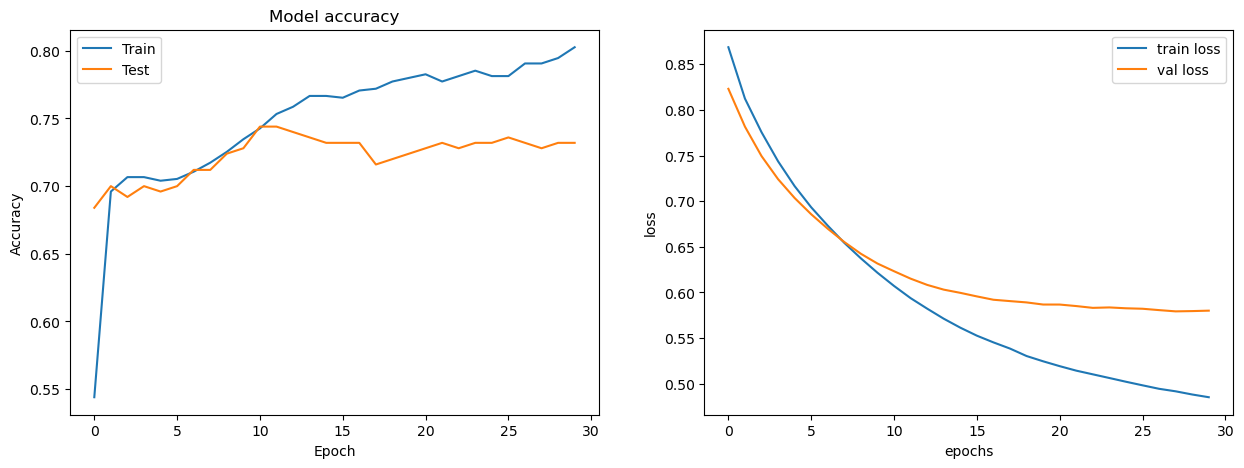

In [25]:
# Plot your model training history and plot loss uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot your model training history
ax1.plot(history3.history['accuracy'])
ax1.plot(history3.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
# Visualize the loss
ax2.plot(history3.history['loss'], label='train loss')
ax2.plot(history3.history['val_loss'], label='val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()
plt.show()

In [29]:
# Exportar las predicciones
y_pred3 = pd.DataFrame(y_pred3)
y_pred3.to_csv('C:/Users/rodlu/OneDrive/Escritorio/Coding_Dojo/Data_Science/Data sets/y_pred3.csv', index=False)

Para comparar los tres modelos de redes neuronales y determinar cuál es el mejor para el proyecto de predicción de si un cliente es bueno para tomar un crédito o no, analicemos las métricas y las técnicas utilizadas en cada modelo:

Primer modelo:

Precision: 0.746

Recall: 0.84

F1: 0.79

Accuracy: 0.688

ROC_AUC: 0.587

Loss: 0.416

Segundo modelo:

Precision: 0.772

Recall: 0.869

F1: 0.817

Accuracy: 0.728

ROC_AUC: 0.634

Loss: 0.404

Tercer modelo:

Precision: 0.781

Recall: 0.857

F1: 0.817

Accuracy: 0.732

ROC_AUC: 0.649

Loss: 0.485

En términos generales, los mejores modelos son aquellos que obtienen altas precisiones, recalls y F1-scores, así como un alto valor de área bajo la curva ROC (ROC_AUC) y una baja pérdida (Loss). Además, es importante considerar las técnicas utilizadas en cada modelo.

El primer modelo no tuvo regularización, lo cual puede hacer que esté más propenso a sobreajustar o tener un rendimiento subóptimo en datos nuevos. Esto se evidencia en las métricas, donde la precisión, el recall y el F1-score son relativamente bajos en comparación con los otros modelos. Además, el área bajo la curva ROC también es el más bajo.

El segundo modelo utilizó la técnica de Early Stopping, lo cual puede ayudar a evitar el sobreajuste. Se observa que este modelo mejora en términos de precisión, recall, F1-score, área bajo la curva ROC y pérdida en comparación con el primer modelo. Sin embargo, aún hay margen de mejora.

El tercer modelo utilizó la regularización L2 (Ridge), que puede ayudar a controlar la complejidad del modelo y reducir el sobreajuste. Este modelo muestra mejoras en todas las métricas en comparación con los anteriores. La precisión, recall, F1-score y área bajo la curva ROC son más altos, y la pérdida es relativamente más baja.

Teniendo en cuenta las métricas y las técnicas utilizadas, el tercer modelo con regularización L2 parece ser el mejor de los tres para el proyecto de predicción de clientes buenos para tomar un crédito o no.En términos generales, los mejores modelos son aquellos que obtienen altas precisiones, recalls y F1-scores, así como un alto valor de área bajo la curva ROC (ROC_AUC) y una baja pérdida (Loss).

Para comparar el mejor modelo supervisado (Regresión Logística) con el mejor modelo no supervisado (Red Neuronal), analicemos las métricas obtenidas en cada uno:

Modelo de Regresión Logística:

Precision: 0.805
Recall: 0.897
F1: 0.849
Accuracy test: 0.776
Accuracy train: 0.768
ROC AUC: 0.695
Modelo de Red Neuronal:

Precision: 0.781
Recall: 0.857
F1: 0.817
Accuracy: 0.732
ROC AUC: 0.649
Loss: 0.485

Al comparar las métricas, observamos que el modelo de Regresión Logística tiene una precisión, recall y F1-score ligeramente superiores en comparación con el modelo de Red Neuronal. Además, el modelo de Regresión Logística muestra un mejor desempeño en términos de Accuracy tanto en el conjunto de prueba como en el conjunto de entrenamiento. En cuanto al área bajo la curva ROC (ROC AUC), ambos modelos muestran valores similares, pero el modelo de Regresión Logística tiene una ligera ventaja.

Dado que el objetivo es predecir si una persona es buena o no para tomar un crédito, el modelo supervisado (Regresión Logística) parece ser más adecuado en este caso. Proporciona un mejor equilibrio entre precisión, recall y F1-score, y tiene un rendimiento superior en términos de Accuracy en ambos conjuntos de datos. Además, al ser un modelo supervisado, se beneficia de utilizar etiquetas de clase conocidas para entrenar y hacer predicciones precisas.


Basado en los resultados proporcionados y considerando las características del dataset (1000 filas, 7 columnas numéricas y 13 columnas categóricas, reducción de dimensionalidad con PCA), así como el objetivo de predecir la idoneidad de una persona para tomar un crédito: 

Recomendaciones para trabajos futuros con este dataset:

Recopilación de más datos: Si es posible, es recomendable aumentar el tamaño del dataset recopilando más datos. Un dataset más grande podría proporcionar una representación más completa de los patrones y relaciones en los datos, lo cual podría mejorar el rendimiento de los modelos.

Exploración adicional de las variables categóricas: Dado que hay 13 columnas categóricas en el dataset, sería beneficioso realizar un análisis más detallado de estas variables. Esto puede incluir la exploración de técnicas de codificación de variables categóricas, como one-hot encoding o codificación ordinal, para capturar mejor la información contenida en estas características.

Optimización de hiperparámetros: En los modelos utilizados hasta ahora, es posible que existan hiperparámetros que se puedan ajustar para mejorar el rendimiento. Se podría explorar la optimización de hiperparámetros mediante técnicas como Grid Search o Random Search para encontrar la combinación óptima de parámetros para cada modelo.

Considerar otros modelos y técnicas: Además de los modelos supervisados utilizados, podría ser beneficioso explorar otros algoritmos de aprendizaje automático y técnicas, como árboles de decisión, Random Forest, Gradient Boosting, SVM, etc. Cada modelo tiene sus fortalezas y debilidades, por lo que probar diferentes enfoques puede proporcionar una visión más completa del problema.

Evaluar la influencia del PCA: Dado que se utilizó PCA para reducir la dimensionalidad del dataset de 52 a 20 características, sería importante evaluar la influencia de esta reducción en el rendimiento de los modelos. Puede ser útil comparar los resultados con y sin PCA para determinar si la reducción de dimensionalidad mejoró o perjudicó el rendimiento.

Dificultades marcantes encontradas en el dataset pueden incluir:

Desbalanceo de clases: Si la proporción entre las clases positivas y negativas en el dataset es muy desigual, puede generar un sesgo en los resultados y afectar el rendimiento del modelo. Sería importante abordar este desbalanceo, por ejemplo, mediante técnicas de muestreo como oversampling o undersampling, o mediante el uso de algoritmos específicos para clasificación desbalanceada.

Calidad y completitud de los datos: La calidad y la completitud de los datos pueden influir en la capacidad de los modelos para aprender patrones y realizar predicciones precisas. Es importante revisar y abordar posibles problemas de datos faltantes, errores o inconsistencias en el dataset antes de aplicar los modelos.

Interpretación de variables categóricas: Las variables categóricas pueden requerir una codificación adecuada para ser utilizadas en los modelos. Es posible que haya dificultades en la selección de la mejor estrategia de codificación y en la interpretación de las variables categóricas en relación con el objetivo de predicción.